In [1]:
import os
import sys
sys.path.append('..')
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from models import UNet

In [2]:
# load data
train_imgs_path = '../data/train/original/'
train_labels_path = '../data/train/ground_truth/'

test_imgs_path = '../data/test/original/'
test_labels_path = '../data/test/ground_truth/'

train_images = []
train_labels = []

test_images = []
test_labels = []

In [3]:
print(os.listdir('..'))

['.git', 'requirements.txt', 'src', 'data', '.gitignore', 'mia_venv', '.github', 'notes.md']


In [4]:
for image_name in os.listdir(train_imgs_path):
    # load train images
    img = Image.open(os.path.join(train_imgs_path, image_name))
    train_images.append(img)
    label = Image.open(os.path.join(train_labels_path, image_name))
    train_labels.append(label)

In [5]:
for image_name in os.listdir(test_imgs_path):
    # load train images
    img = Image.open(os.path.join(test_imgs_path, image_name))
    test_images.append(img)
    label = Image.open(os.path.join(test_labels_path, image_name))
    test_labels.append(label)

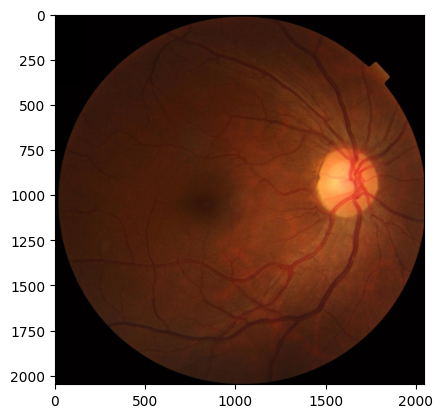

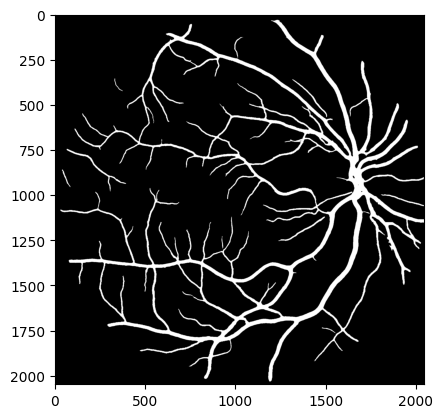

: 

In [ ]:
# show Pngimagefile
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0])
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = TensorDataset(torch.stack([transform(img) for img in train_images]),
                              torch.stack([transform(lbl) for lbl in train_labels]))

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_dataset = TensorDataset(torch.stack([transform(img) for img in test_images]),
                             torch.stack([transform(lbl) for lbl in test_labels]))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1,1).to(device)

EPOCHS = 30
LR = 0.0001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
losses = [] 
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss/len(train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


In [ ]:
plt.plot(range(1, 30 + 1), losses,color='green')
plt.plot(range(1, 30 + 1), val_losses,color='pink')